Below takes pcr swap probabilities and gapfill error probabilities for predefined feature set and returns cell genotypes with probabilities.
This should be pretty generic but may need adjustment if there are multiple possible alleles for the same probe

In [1]:
import sys
from gapfill_utilities import utils as gf_utils
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations
# sys.path.append('/home/blattms1/projects/gapfill/4CL_JAK2/likelihood_model/src/')
# import utils as lm_utils
import scanpy as sc



In [2]:
lib = '1'


In [ ]:
## these are now in lm_utils but there is an error
def get_p(allele1,allele2,fracs_1,sub_probe_reads):
    prob_columns = []
    for frac_1 in fracs_1:
        frac_2 = 1 - frac_1
        sub_probe_reads[allele1] = sub_probe_reads['p_' + allele1] * frac_1
        sub_probe_reads[allele2] = sub_probe_reads['p_' + allele2] * frac_2
        col_name = 'p_' + allele1 + '_' + allele2 + '_' + str(frac_1) + '_' + str(frac_2)
        sub_probe_reads[col_name] = sub_probe_reads[['pcr_swap_likelihood', allele1, allele2]].max(axis=1)
        prob_columns.append(col_name)
        allele_call_col = col_name.replace('p_','') + '_n_allele_1'
        sub_probe_reads[allele_call_col] = sub_probe_reads[['pcr_swap_likelihood', allele1, allele2]].idxmax(axis=1)
        sub_probe_reads.loc[sub_probe_reads[allele_call_col] == 'pcr_swap_likelihood',allele_call_col] = None
        sub_probe_reads.loc[sub_probe_reads[allele_call_col] == allele2,allele_call_col] = 0
        sub_probe_reads.loc[sub_probe_reads[allele_call_col] == allele1,allele_call_col] = 1
        sub_probe_reads.drop(columns=[allele1, allele2], inplace=True)
    return sub_probe_reads, prob_columns

def update_het_frac(sub_probe_reads, prob_columns):
    cell_genotypes = sub_probe_reads.groupby(['cell_idx', 'barcode'])[prob_columns].prod()
    cell_genotypes = cell_genotypes.div(cell_genotypes.sum(axis=1), axis=0)
    het_cols = cell_genotypes.columns[~(cell_genotypes.columns.str.contains('0_1') | cell_genotypes.columns.str.contains('1_0'))]
    het_cells = cell_genotypes.loc[cell_genotypes[het_cols].sum(axis=1) > 0.8].index.get_level_values('barcode').unique()
    if len(het_cells) > 20:
        cols = sub_probe_reads.columns[(sub_probe_reads.columns.str.contains('n_allele_1')) & ~(sub_probe_reads.columns.str.contains('0_1')) & ~(sub_probe_reads.columns.str.contains('1_0'))]
        updated_frac1 = sub_probe_reads.loc[sub_probe_reads['barcode'].isin(het_cells)].groupby(['cell_idx','barcode'])[cols].mean().mean().mean()
        return updated_frac1
    else:
        return 0.5

def rename_genotype_columns(cell_genotypes, genotype_names):
    for col in cell_genotypes.columns:
        if col.endswith('0_1'):
            call = col.split('_')[2]
            if ((genotype_names['gapfill_value']) == call).sum() > 0:
                variant_name = genotype_names.loc[genotype_names['gapfill_value'] == call]['name'].values[0]
                variant_type = genotype_names.loc[genotype_names['gapfill_value'] == call]['variant'].map({False : '_wt', True : '_mutated'}).values[0]
                new_col_name = variant_name + variant_type
                cell_genotypes.rename(columns={col: new_col_name}, inplace=True)
        elif col.endswith('1_0'):
            call = col.split('_')[1]
            if ((genotype_names['gapfill_value']) == call).sum() > 0:
                variant_name = genotype_names.loc[genotype_names['gapfill_value'] == call]['name'].values[0]
                variant_type = genotype_names.loc[genotype_names['gapfill_value'] == call]['variant'].map({False : '_wt', True : '_mutated'}).values[0]
                new_col_name = variant_name + variant_type
                cell_genotypes.rename(columns={col: new_col_name}, inplace=True)
        else:
            call1 = col.split('_')[1]
            call2 = col.split('_')[2]
            if (((genotype_names['gapfill_value']) == call1).sum() > 0) & (((genotype_names['gapfill_value']) == call2).sum() > 0):
                variants = genotype_names.loc[(genotype_names['gapfill_value'] == call1) | (genotype_names['gapfill_value'] == call2)]
                variant_name = variants.loc[variants['variant'] == True]['name'].values[0]
                variant_type = '_heterozygous'
                new_col_name = variant_name + variant_type
                cell_genotypes.rename(columns={col: new_col_name}, inplace=True)
    return cell_genotypes

def get_cell_genotypes(probe_idx,probe_reads,genotype_names,fracs_1 = [0,0.5,1], learn_het_frac = True):
    sub_probe_reads = probe_reads.loc[probe_reads['probe_idx'] == probe_idx]
    sub_probe_reads = sub_probe_reads.dropna(axis=1, how='all')
    possible_alleles = sub_probe_reads.columns[sub_probe_reads.columns.str.contains('p_gapfill_given_')]
    sub_probe_reads[possible_alleles.str.replace('_gapfill_given','')] = sub_probe_reads[possible_alleles].div(sub_probe_reads[possible_alleles].sum(axis=1), axis=0)
    sub_probe_reads = sub_probe_reads.drop(columns=possible_alleles)
    possible_alleles = possible_alleles.str.replace('p_gapfill_given_','')
    for allele_combination in list(combinations(possible_alleles, 2)):
        allele1 = allele_combination[0]
        allele2 = allele_combination[1]
        sub_probe_reads, prob_columns = get_p(allele1, allele2, fracs_1, sub_probe_reads)
        if learn_het_frac:
            updated_het_frac = np.round(update_het_frac(sub_probe_reads, prob_columns),2)
            sub_probe_reads, prob_columns = get_p(allele1, allele2, [0,updated_het_frac,1], sub_probe_reads)
    cell_genotypes = sub_probe_reads.groupby(['cell_idx', 'barcode'])[prob_columns].prod()
    cell_genotypes = cell_genotypes.div(cell_genotypes.sum(axis=1), axis=0)
    cell_genotypes = rename_genotype_columns(cell_genotypes, genotype_names)
    cell_genotypes = cell_genotypes.reset_index()
    probe_name = cell_genotypes.columns[cell_genotypes.columns.str.contains('_mutated')].str.replace('_mutated','')[0]
    cell_genotypes[probe_name + '_high_confidence_counts'] = cell_genotypes['barcode'].map(sub_probe_reads.loc[sub_probe_reads['pcr_swap_likelihood'] < 0.1]['barcode'].value_counts().to_dict()).fillna(0)
    return cell_genotypes

Processing BC: BC001


568648 UMIs found


Collapsing UMIs across probes, 568648 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 566830 UMIs remaining (99.68%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 553555 UMIs remaining (97.35%)


674061 UMIs found


Collapsing UMIs across probes, 674061 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 671947 UMIs remaining (99.69%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 655189 UMIs remaining (97.20%)


/tmp/ipykernel_2377248/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


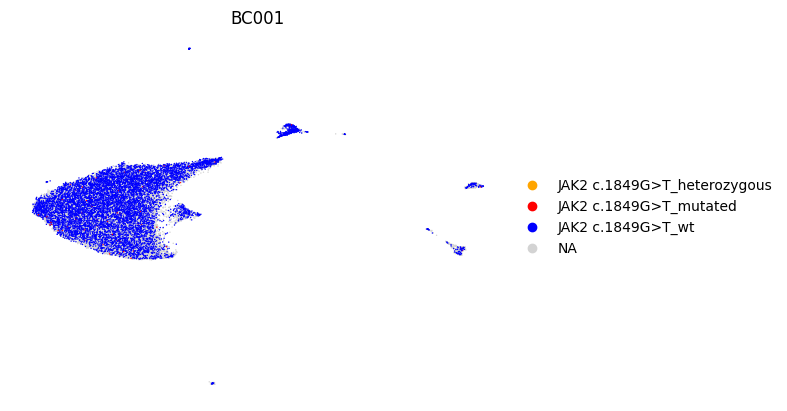

Processing BC: BC002


387979 UMIs found


Collapsing UMIs across probes, 387979 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 386424 UMIs remaining (99.60%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 366951 UMIs remaining (94.58%)


447368 UMIs found


Collapsing UMIs across probes, 447368 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 445728 UMIs remaining (99.63%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 417432 UMIs remaining (93.31%)


/tmp/ipykernel_2377248/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


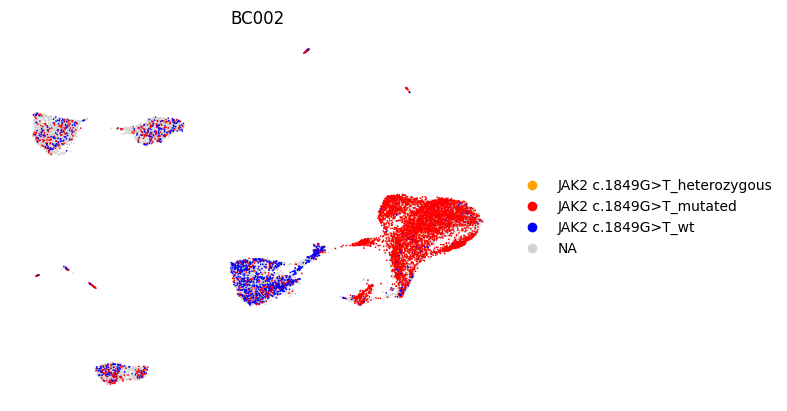

Processing BC: BC003


616887 UMIs found


Collapsing UMIs across probes, 616887 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 614468 UMIs remaining (99.61%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 593738 UMIs remaining (96.25%)


720635 UMIs found


Collapsing UMIs across probes, 720635 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 717840 UMIs remaining (99.61%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 687066 UMIs remaining (95.34%)


/tmp/ipykernel_2377248/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


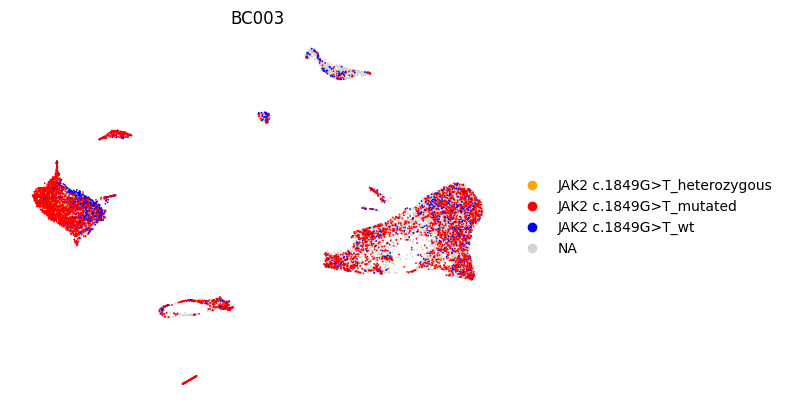

Processing BC: BC004


917786 UMIs found


Collapsing UMIs across probes, 917786 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 914057 UMIs remaining (99.59%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 852264 UMIs remaining (92.86%)


1111593 UMIs found


Collapsing UMIs across probes, 1111593 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1107432 UMIs remaining (99.63%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1020593 UMIs remaining (91.81%)


/tmp/ipykernel_2377248/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


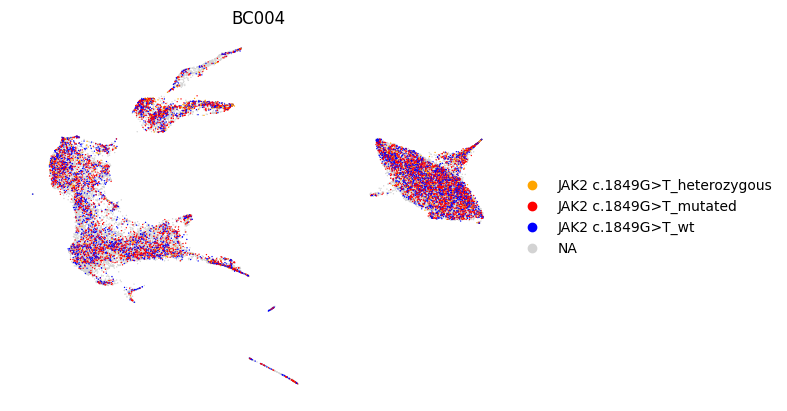

Processing BC: BC005


1419549 UMIs found


Collapsing UMIs across probes, 1419549 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1414497 UMIs remaining (99.64%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1364100 UMIs remaining (96.09%)


1645255 UMIs found


Collapsing UMIs across probes, 1645255 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1639748 UMIs remaining (99.67%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1580943 UMIs remaining (96.09%)


/tmp/ipykernel_2377248/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


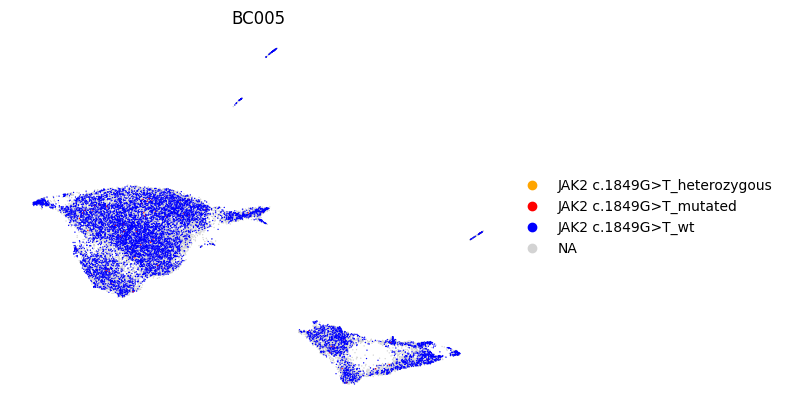

Processing BC: BC006


1994670 UMIs found


Collapsing UMIs across probes, 1994670 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1987444 UMIs remaining (99.64%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1861145 UMIs remaining (93.31%)


2261733 UMIs found


Collapsing UMIs across probes, 2261733 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 2254124 UMIs remaining (99.66%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 2089567 UMIs remaining (92.39%)


/tmp/ipykernel_2377248/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


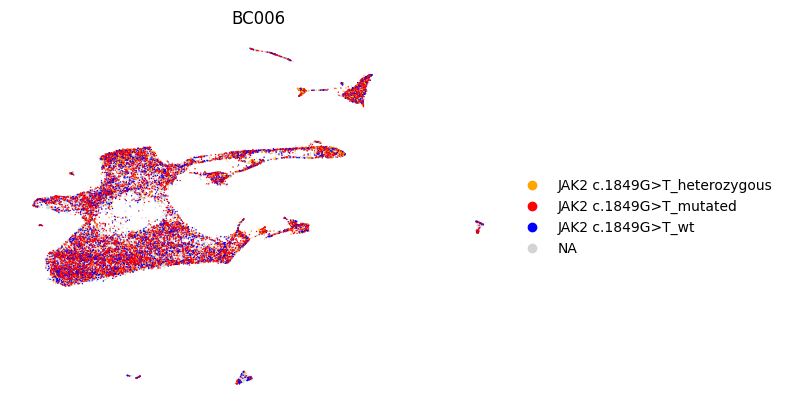

Processing BC: BC007


1756198 UMIs found


Collapsing UMIs across probes, 1756198 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1749625 UMIs remaining (99.63%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1613208 UMIs remaining (91.86%)


2010873 UMIs found


Collapsing UMIs across probes, 2010873 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 2003477 UMIs remaining (99.63%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1828215 UMIs remaining (90.92%)


/tmp/ipykernel_2377248/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


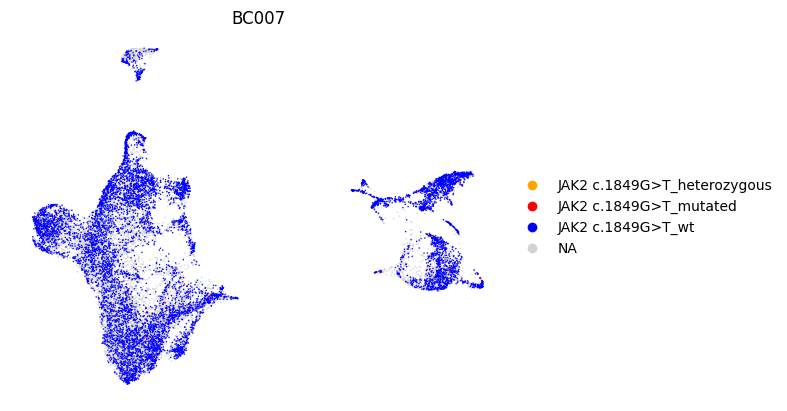

Processing BC: BC008
45584 UMIs found
Collapsing UMIs across probes, 45584 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 45445 UMIs remaining (99.70%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 44990 UMIs remaining (98.70%)
55256 UMIs found
Collapsing UMIs across probes, 55256 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 55122 UMIs remaining (99.76%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 40745 UMIs remaining (73.74%)


/tmp/ipykernel_2377248/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


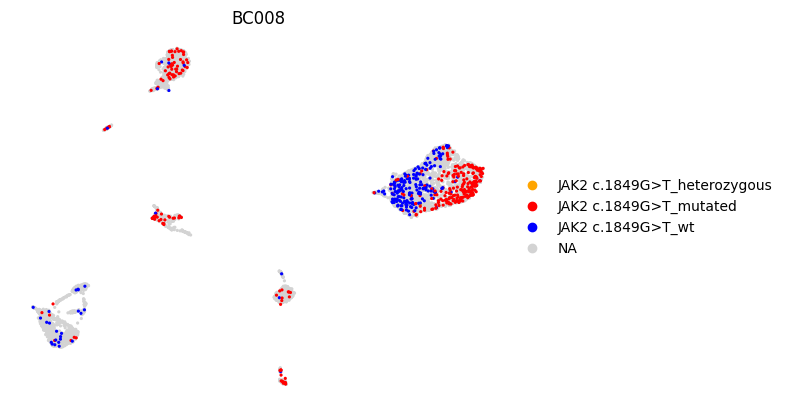

Processing BC: BC009
58081 UMIs found
Collapsing UMIs across probes, 58081 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 57917 UMIs remaining (99.72%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 57091 UMIs remaining (98.30%)
74056 UMIs found
Collapsing UMIs across probes, 74056 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 73835 UMIs remaining (99.70%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 65548 UMIs remaining (88.51%)


/tmp/ipykernel_2377248/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


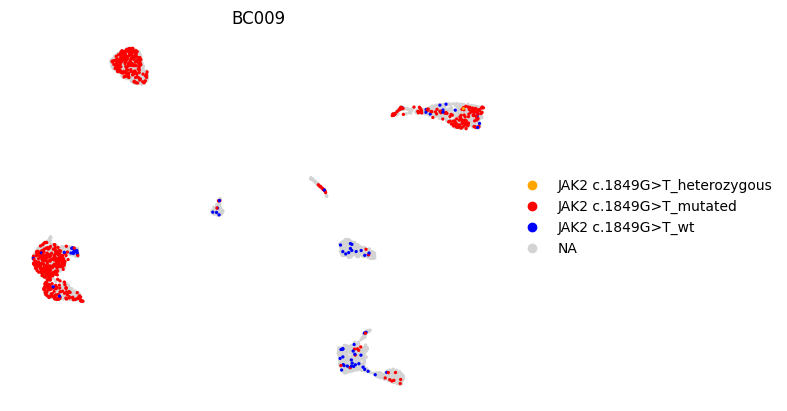

Processing BC: BC010


2292046 UMIs found


Collapsing UMIs across probes, 2292046 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 2281933 UMIs remaining (99.56%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 2106774 UMIs remaining (91.92%)


2796720 UMIs found


Collapsing UMIs across probes, 2796720 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 2785174 UMIs remaining (99.59%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 2571310 UMIs remaining (91.94%)


/tmp/ipykernel_2377248/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


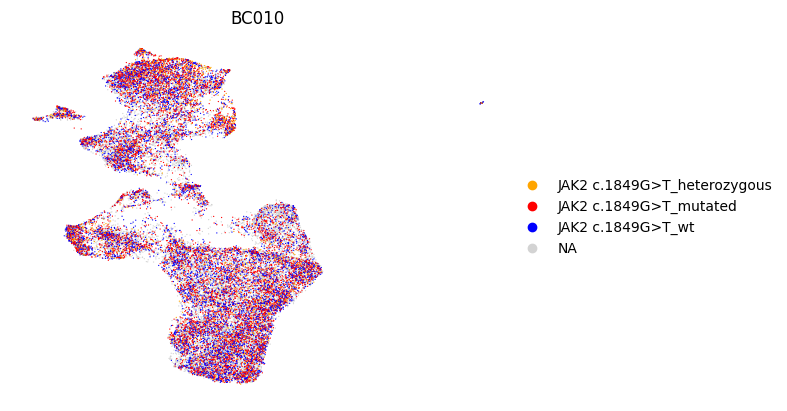

Processing BC: BC011


1138142 UMIs found


Collapsing UMIs across probes, 1138142 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1133722 UMIs remaining (99.61%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1054189 UMIs remaining (92.62%)


1271503 UMIs found


Collapsing UMIs across probes, 1271503 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1266866 UMIs remaining (99.64%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1082304 UMIs remaining (85.12%)


/tmp/ipykernel_2377248/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


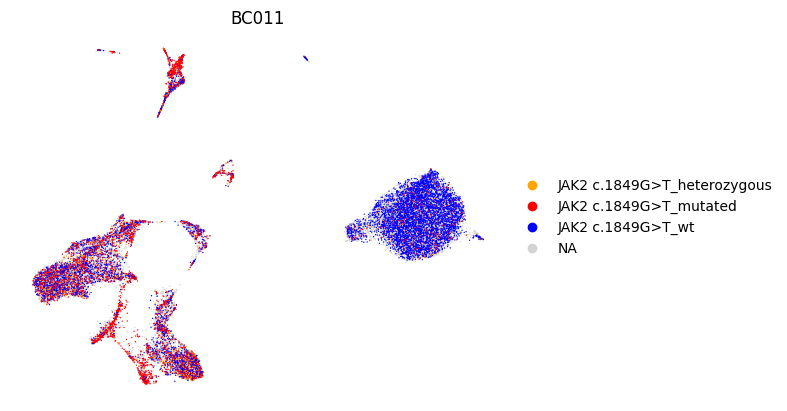

Processing BC: BC012


1345020 UMIs found


Collapsing UMIs across probes, 1345020 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1339466 UMIs remaining (99.59%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1288440 UMIs remaining (95.79%)


1558831 UMIs found


Collapsing UMIs across probes, 1558831 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1552968 UMIs remaining (99.62%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1480120 UMIs remaining (94.95%)


/tmp/ipykernel_2377248/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


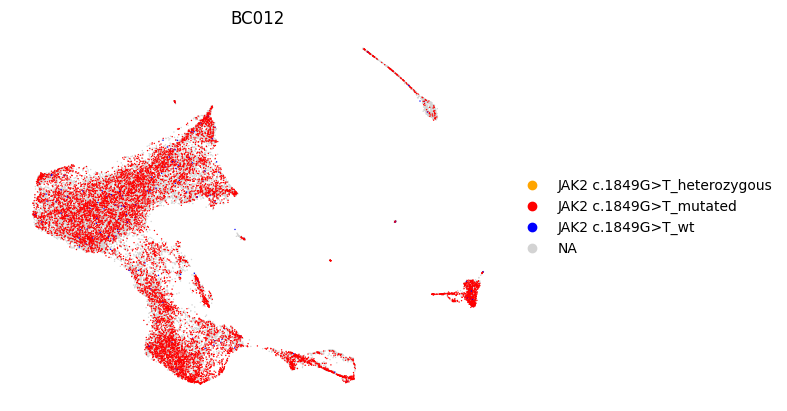

Processing BC: BC013


1450740 UMIs found


Collapsing UMIs across probes, 1450740 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1445663 UMIs remaining (99.65%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1401531 UMIs remaining (96.61%)


1651562 UMIs found


Collapsing UMIs across probes, 1651562 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1646034 UMIs remaining (99.67%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1587987 UMIs remaining (96.15%)


/tmp/ipykernel_2377248/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


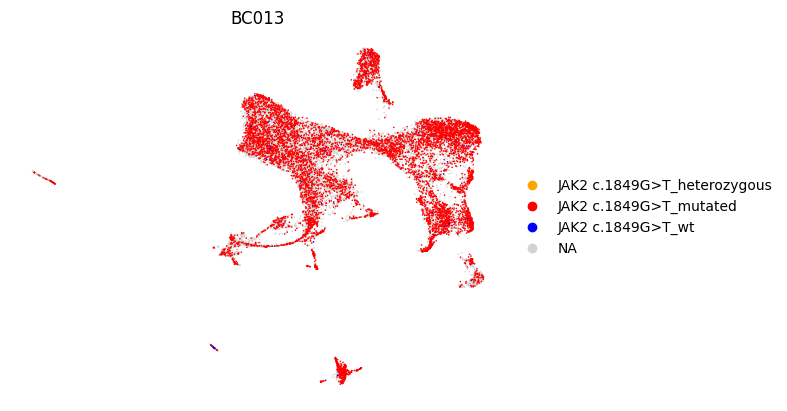

Processing BC: BC014
139217 UMIs found
Collapsing UMIs across probes, 139217 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 138856 UMIs remaining (99.74%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 132953 UMIs remaining (95.50%)
179556 UMIs found


Collapsing UMIs across probes, 179556 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 179076 UMIs remaining (99.73%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 171766 UMIs remaining (95.66%)


/tmp/ipykernel_2377248/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


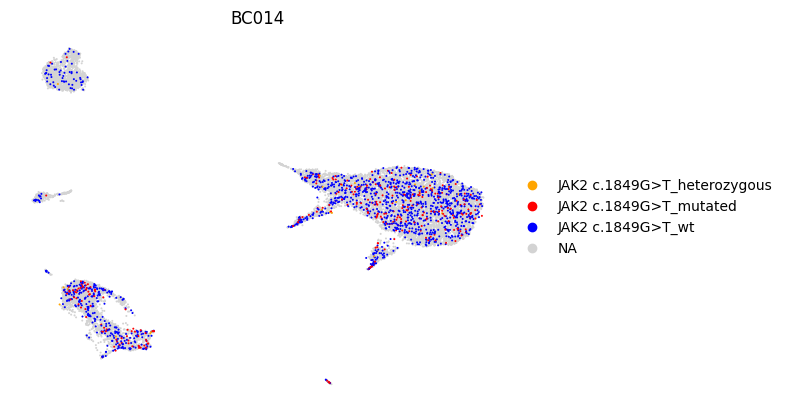

Processing BC: BC015


1729224 UMIs found


Collapsing UMIs across probes, 1729224 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1722106 UMIs remaining (99.59%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1611729 UMIs remaining (93.21%)


2009030 UMIs found


Collapsing UMIs across probes, 2009030 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 2001147 UMIs remaining (99.61%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1857143 UMIs remaining (92.44%)


/tmp/ipykernel_2377248/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


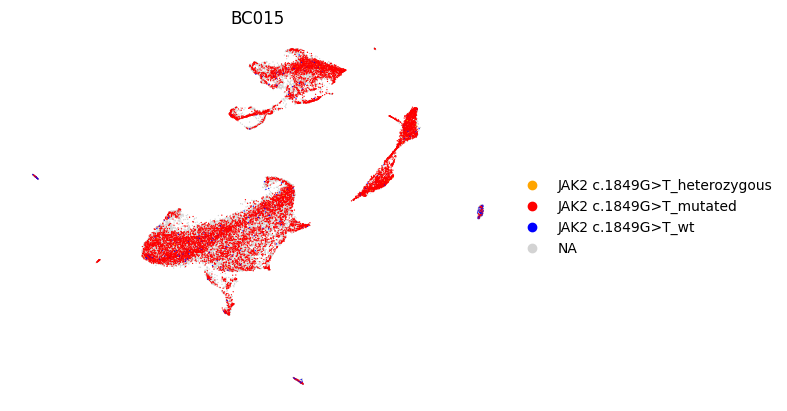

Processing BC: BC016


1368673 UMIs found


Collapsing UMIs across probes, 1368673 UMIs remaining (100.00%)
Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1361869 UMIs remaining (99.50%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1298549 UMIs remaining (94.88%)


1630738 UMIs found


Collapsing UMIs across probes, 1630738 UMIs remaining (100.00%)


Filtering probe reads based on read threshold (0) and min percent supporting (0.9), 1623116 UMIs remaining (99.53%)


Filtering cells based on min counts (0) and genes (0) in WTA


Filtering probe reads based on cell barcodes in adata, 1550467 UMIs remaining (95.08%)


/tmp/ipykernel_2377248/3252034222.py:50: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)


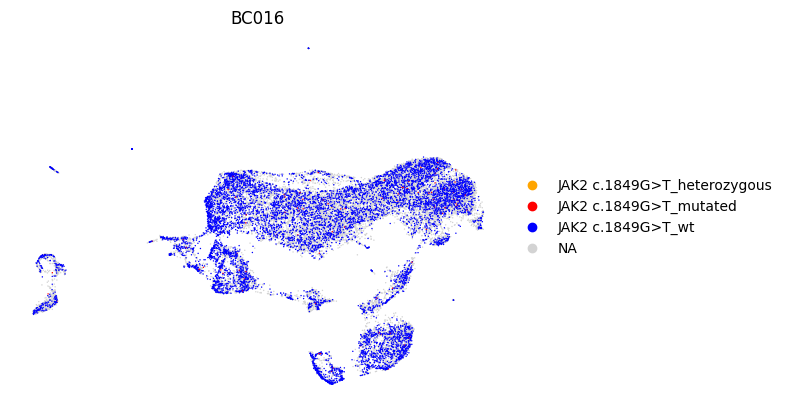

In [4]:
for BC in ['BC001', 'BC002', 'BC003', 'BC004', 'BC005', 'BC006', 'BC007', 'BC008', 'BC009', 'BC010', 'BC011', 'BC012', 'BC013', 'BC014', 'BC015', 'BC016']:
    print('Processing BC:', BC)
    adata_path = '/data1/lareauc/users/blattms/gapfill/wta_adata/20250605_MPN_' + lib + '_' + BC + '.h5ad'
    gf_dirs = {}
    gf_dirs[0] = '/data1/lareauc/projects/gapfill/analysis/20250605_MPN_16plex/gf_MPN_16plex_part' + lib + '_1/BC' + str(int(BC.replace('BC',''))) + '_giftwrap/'
    gf_dirs[1] = '/data1/lareauc/projects/gapfill/analysis/20250605_MPN_16plex/gf_MPN_16plex_part' + lib + '_2/BC' + str(int(BC.replace('BC',''))) + '_giftwrap/'
    min_percent_supporting = 0.9
    collapse_across_probes = True
    for key,gf_dir in gf_dirs.items():
        if key == 0:
            probe_reads = gf_utils.get_input_probe_reads(gf_dir, read_threshold = 0, cell_barcode_suffix = '-' + str(key), adata_path = adata_path, min_percent_supporting=min_percent_supporting, collapse_across_probes=collapse_across_probes)
        else:
            probe_reads = pd.concat([probe_reads, gf_utils.get_input_probe_reads(gf_dir, read_threshold = 0, cell_barcode_suffix = '-' + str(key), adata_path = adata_path, min_percent_supporting=min_percent_supporting, collapse_across_probes=collapse_across_probes)], ignore_index=True)

    gapfill_likelihoods = pd.read_csv('likelihood_tables/' + BC + '_gapfill_likelihoods.csv')
    columns_to_rename = gapfill_likelihoods.columns.difference(['probe_idx', 'gapfill'])
    gapfill_likelihoods.rename(columns={col: 'p_gapfill_given_' + col for col in columns_to_rename}, inplace=True)

    pcr_swap_likelihoods = pd.read_csv('likelihood_tables/patient_' + BC + '_swap_probabilities.csv')
    pcr_swap_likelihoods.rename(columns={'likelihood':'no_pcr_swap_likelihood'}, inplace=True)
    pcr_swap_likelihoods['pcr_swap_likelihood'] = 1 - pcr_swap_likelihoods['no_pcr_swap_likelihood']

    variant_probes = gapfill_likelihoods['probe_idx'].unique()
    probe_reads = probe_reads.loc[probe_reads['probe_idx'].isin(variant_probes)]
    probe_reads = probe_reads.merge(gapfill_likelihoods, how='left', on = ['probe_idx','gapfill'])
    probe_reads = probe_reads.merge(pcr_swap_likelihoods[['pcr_duplicate_count','pcr_swap_likelihood']], how='left', on = 'pcr_duplicate_count')
    probe_reads.drop(['umi','percent_supporting','probe_barcode'],axis=1, inplace=True)

    alt_genotypes = pd.read_csv('likelihood_tables/all_gapfill_features_filtered_combined.csv')
    manifest = gf_utils.get_manifest(gf_dirs[0])
    probe_name_to_probe_idx = dict(zip(manifest['name'], manifest['index']))
    alt_genotypes['probe_idx'] = alt_genotypes['name'].map(probe_name_to_probe_idx)

    alt_genotypes = pd.concat([
        alt_genotypes[['probe_idx', 'name', 'gapfill']].rename(columns={'gapfill': 'gapfill_value'}).assign(variant=True),
        alt_genotypes[['probe_idx', 'name', 'gapfill_from_transcriptome']].rename(columns={'gapfill_from_transcriptome': 'gapfill_value'}).assign(variant=False)
    ], ignore_index=True)

    cell_genotypes = {}
    for probe_idx in probe_reads['probe_idx'].unique():
        cell_genotypes[probe_idx] = get_cell_genotypes(probe_idx,probe_reads, alt_genotypes.loc[alt_genotypes['probe_idx'] == probe_idx], learn_het_frac = False)

    all_df = pd.DataFrame()
    for probe_idx in cell_genotypes.keys():
        df = cell_genotypes[probe_idx].set_index('barcode').drop(['cell_idx'],axis=1)
        all_df = all_df.merge(df, how='outer', left_index=True, right_index=True)

    adata = gf_utils.read_adata(adata_path)
    adata.obsm['genotypes'] = all_df.reindex(adata.obs_names)
    adata.obs['genotype'] = adata.obsm['genotypes'][['JAK2 c.1849G>T_mutated','JAK2 c.1849G>T_heterozygous','JAK2 c.1849G>T_wt']].idxmax(axis=1)
    sc.pl.umap(adata, color='genotype', frameon=False, palette={'JAK2 c.1849G>T_mutated':'red','JAK2 c.1849G>T_wt':'blue','JAK2 c.1849G>T_heterozygous':'orange'}, title = BC)
    adata.write(adata_path.replace('.h5ad','_genotyped.h5ad'))
